# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from sklearn.linear_model import LinearRegression
%matplotlib inline

# SOLUTION

## Default params

In [3]:
class Params:
    # Canny edge detection params
    kernel_size = 3
    canny_low_th = 90
    canny_high_th = 150
    # ROI params
    # Relative parameters, as image sizes may vary
    roi_middle_x_width = 0.15
    roi_middle_y_shift = 0.1
    roi_bottom_y_shift = 0.0
    roi_bottom_x_width = 1.0
    @property
    def roi(self):
        # fillPoly requres list of polygons, so list, of lists of points is required
        return np.array([[
                (0.5 - self.roi_bottom_x_width / 2, 1 - self.roi_bottom_y_shift),
                ((1 - self.roi_middle_x_width) / 2, 0.5 + self.roi_middle_y_shift),
                ((1 + self.roi_middle_x_width) / 2, 0.5 + self.roi_middle_y_shift),
                (0.5 + self.roi_bottom_x_width / 2, 1 - self.roi_bottom_y_shift),
            ]],
            dtype=np.float32)
    # Hough transform params
    hough_rho = 1
    hough_theta = np.pi / 180
    hough_th = 10
    hough_min_line_len = 25
    hough_max_line_gap = 30
    filter_coef = 0.05

## Filter

In [4]:
class Filter:
    lm = 0
    lb = 0
    rm = 0
    rb = 0
    cnt = 0
    def update(self, rm, rb, lm, lb, coef):
        if self.cnt == 0:
            self.lm = lm
            self.lb = lb
            self.rm = rm
            self.rb = rb
        else:
            self.lm = self.lm * (1 - coef) + coef * lm
            self.lb = self.lb * (1 - coef) + coef * lb
            self.rm = self.rm * (1 - coef) + coef * rm
            self.rb = self.rb * (1 - coef) + coef * rb    
        self.cnt += 1
            

## Helpers

In [23]:
def print_lines(img, lines, color=(255, 0, 0), width=4):
    if lines is None:
        return
    for line in lines:
        x1, y1, x2, y2 = tuple(*line)
        cv2.line(img, (x1, y1), (x2, y2), color, width)
    
def print_model(img, m, b, x1, x2, color):
    cv2.line(img, (int(x1), int(b + m * x1)), (int(x2), int(b + m * x2)), color, 5)
    
def open_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def roi(img, vertices):
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (0xff,) * channel_count
    else:
        ignore_mask_color = 0xff
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def direction(x1, y1, x2, y2):
    if y2 < y1:
        y1, y2 = y2, y1
        x1, x2 = x2, x1
    # ----------------> x
    # |       .(x1,y1)
    # | 
    # |   .(x2,y2)
    # v y
    dy = y2 - y1 # always > 0, pointing downwards
    dx = x2 - x1
    # ----------------> x
    #     /|\
    #    / | \
    #   /+ | -\
    #      v
    sine = -dx / (dx*dx+dy*dy) ** 0.5
    return np.arcsin(sine) / np.pi * 180

def show_image(images):
    fig = plt.figure(figsize=(12, len(images) * 8))
    fig.subplots(len(images), 1)
    for idx, img in enumerate(images):
        plt.subplot(len(images), 1, idx+1)
        plt.imshow(img)

## Main function

In [24]:
def get_lines(image, params):
    sz_y, sz_x = image.shape[:2]
    img_rgb = image
    gamma_ = 1.3
    img_rgb = np.power(img_rgb / 255.0, gamma_) * 255.0
    img_rgb = img_rgb.astype(np.uint8)
    #=== FIND EDGES
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_blurred = cv2.GaussianBlur(img_gray, (params.kernel_size, params.kernel_size), 0)
    img_edges = cv2.Canny(img_blurred, params.canny_low_th, params.canny_high_th)
    #=== SELECT ROI
    roi_vertices = params.roi * np.array([sz_x, sz_y])
    roi_vertices = roi_vertices.astype(np.int32)
    img_edges_roi = roi(img_edges, roi_vertices)
    #=== FIND LINES
    lines = cv2.HoughLinesP(
        img_edges_roi, params.hough_rho, params.hough_theta, params.hough_th,
        np.array([]), params.hough_min_line_len, params.hough_max_line_gap)
    return lines
    
def find_lanes(image, params, model_filter):
    """
    Parameters:
        image: RGB image, numpy array
    Returns:
        numpy array, image with lines
    """
    sz_y, sz_x = image.shape[:2]
    img_rgb = image
    roi_vertices = params.roi * np.array([sz_x, sz_y])
    roi_vertices = roi_vertices.astype(np.int32)
    img_rgb_roi = roi(img_rgb, roi_vertices)
    lines = get_lines(img_rgb, params)
    
    #=== DETECT LEFT/RIGHT LANE
    left_lines = []
    right_lines = []
    for line in lines:
        x1, y1, x2, y2 = tuple(*line)
        d = direction(x1, y1, x2, y2)
        if d < 0 and d > -90:
            right_lines += [[x1, y1], [x2, y2]]
        if d > 0 and d < 90:
            left_lines += [[x1, y1], [x2, y2]]
    right_lines = np.array(right_lines)
    left_lines = np.array(left_lines)
    rx = right_lines[:,0].reshape(-1,1)
    ry = right_lines[:,1].reshape(-1,1)
    lx = left_lines[:,0].reshape(-1,1)
    ly = left_lines[:,1].reshape(-1,1)

    rmodel = LinearRegression().fit(rx, ry)
    lmodel = LinearRegression().fit(lx, ly)
    model_filter.update(rmodel.coef_, rmodel.intercept_, lmodel.coef_, lmodel.intercept_, params.filter_coef)
    
    print_model(img_rgb, model_filter.rm, model_filter.rb, sz_x / 2, sz_x, (255, 0, 0))
    print_model(img_rgb,  model_filter.lm, model_filter.lb, 0, sz_x / 2, (0, 255, 0))
    roi_overlay = 0.6
    img_prev = (img_rgb * (1 - roi_overlay) + img_rgb_roi * roi_overlay).astype(np.uint8)
    return img_prev

## Test images

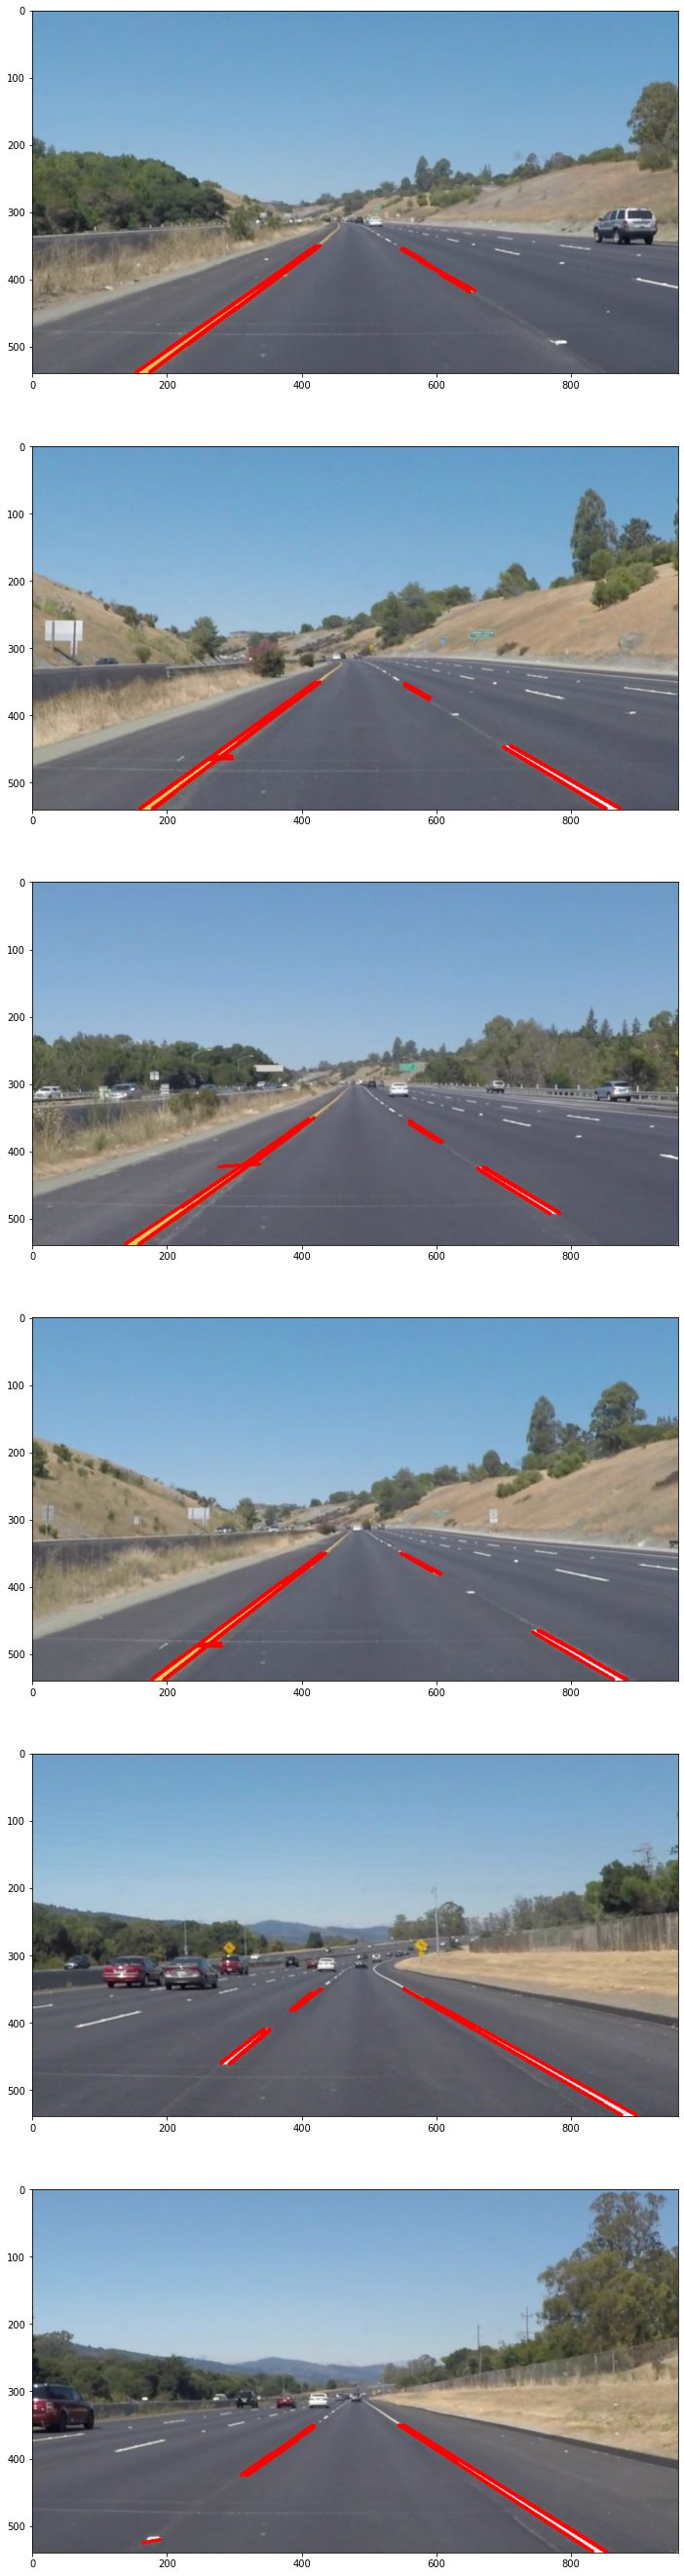

In [28]:
results = []
!mkdir -p test_images_output

params = Params()
params.roi_middle_y_shift = 0.15

for f in os.listdir("test_images/"):
    path = os.path.join('test_images', f)
    img = open_image(path)
    lines = get_lines(img, params=params)
    print_lines(img, lines)
    results += [img]
    cv2.imwrite(os.path.join('test_images_output', f), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
show_image(results)

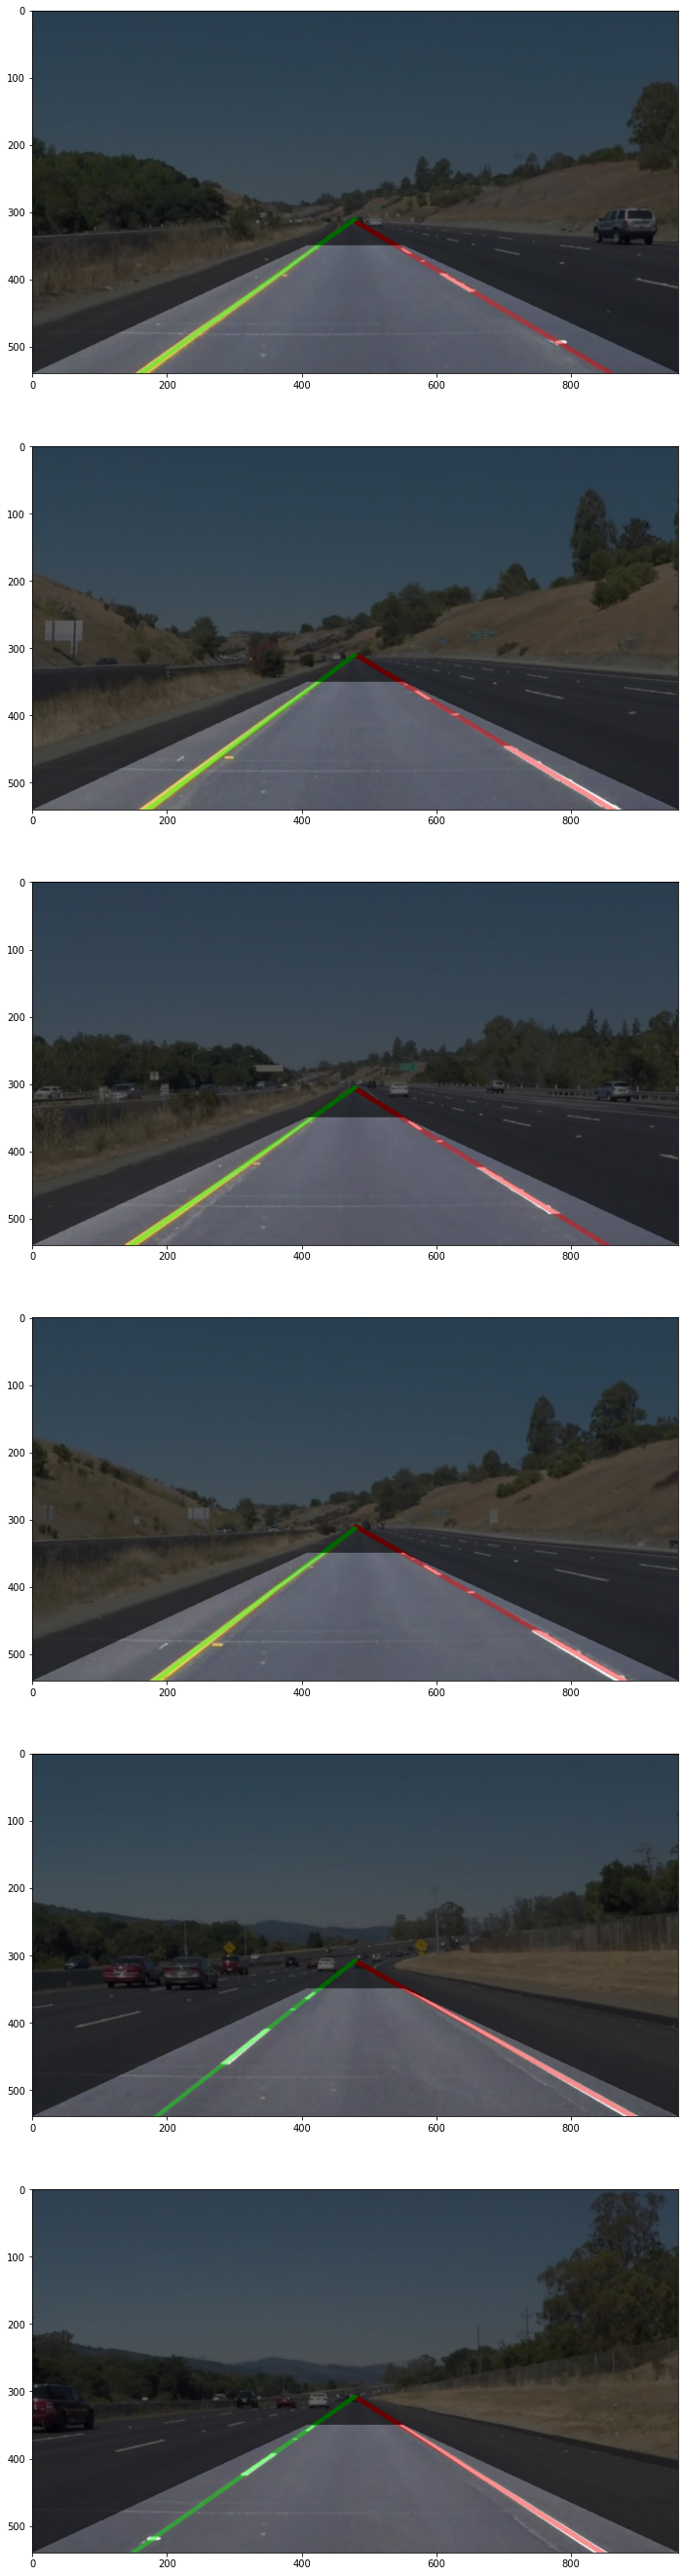

In [38]:
# Draw some lanes
results = []
!mkdir -p test_images_output_lanes

params = Params()
params.roi_middle_y_shift = 0.15

for f in os.listdir("test_images/"):
    path = os.path.join('test_images', f)
    img = open_image(path)
    img = find_lanes(img, params=params, model_filter=Filter())
    results += [img]
    cv2.imwrite(os.path.join('test_images_output_lanes', f), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
show_image(results)

## Video 1 - draw lines on lanes

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

params1 = Params()
# move ROI a bit down to not catch that white car
params1.roi_middle_y_shift = 0.15

def process_image1(image):
    global params1
    lines = get_lines(image, params=params1)
    print_lines(image, lines)
    return image

white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image1)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

t:   1%|▏         | 3/221 [00:00<00:08, 25.57it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 12.9 s, sys: 962 ms, total: 13.8 s
Wall time: 10.5 s


## Video 2 - extrapolate lanes

In [35]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

filter2 = Filter()
params2 = Params()
params2.roi_bottom_y_shift = 0
params2.roi_bottom_x_width = 1
params2.roi_middle_x_width = 0.08

def process_image2(image):
    global params2, filter2
    return find_lanes(image, params2, filter2)
yellow_clip = clip2.fl_image(process_image2)

%time yellow_clip.write_videofile(yellow_output, audio=False)

In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Video 3

The solution does not work very well here.

In [36]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

filter3 = Filter()
params3 = Params()
params3.roi_bottom_x_width = 0.85
params3.roi_middle_x_width = 0.08
params3.roi_bottom_y_shift = 0.05
params3.roi_bottom_x_width = 0.9

def process_image3(image):
    global params3, filter3
    return find_lanes(image, params3, filter3)

challenge_clip = clip3.fl_image(process_image3)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

t:   1%|          | 2/251 [00:00<00:13, 18.50it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 29.1 s, sys: 4.94 s, total: 34 s
Wall time: 29.1 s
